# Preposseing of the crsp data 

In [14]:
# Load libraries
import pandas as pd
import numpy as np
from pandas.api.types import CategoricalDtype
from datetime import datetime
import pandas as pd
from urllib.request import urlopen

In [32]:
# Read CSV data from URL
df = pd.read_csv("/Users/jensknudsen/Desktop/seminar/datashare.csv")

# make a new column with the date as a datetime object
df['datetime'] = pd.to_datetime(df['DATE'].astype(str), format='%Y%m%d')

# make a function that findt the first day of the closest month
def get_closest_first_day(date):
    year = date.year
    month = date.month
    day = date.day
    if day > 15:
        if month == 12:
            month = 1
            year += 1
        else:
            month += 1
    return datetime.datetime(year, month, 1)

# apply the function to the dataframe
df['month'] = df['datetime'].apply(get_closest_first_day)

# delete the not used date columns
del df["DATE"]
del df["datetime"]

# make chareacteristic variables
df = df.rename(columns={col: f"characteristic_{col}" for col in df.columns if col not in ["permno", "month", "sic2"]})

,permno,characteristic_mvel1,characteristic_beta,characteristic_betasq,characteristic_chmom,characteristic_dolvol,characteristic_idiovol,characteristic_indmom,characteristic_mom1m,characteristic_mom6m,...,characteristic_ms,characteristic_baspread,characteristic_ill,characteristic_maxret,characteristic_retvol,characteristic_std_dolvol,characteristic_std_turn,characteristic_zerotrade,sic2,month
0,10006,8.630850e+04,1.117907,1.249717,0.134574,10.296745,0.024863,0.059540,0.002016,0.081150,...,NaN,0.013856,1.557681e-07,0.029167,0.013546,0.914592,0.802461,1.066005e-07,37.0,1957-04-01
1,10014,3.903375e+03,0.331304,0.109762,0.006667,7.032404,0.065248,0.059540,-0.086957,-0.080000,...,NaN,0.031389,8.383815e-06,0.071429,0.031165,0.943409,0.716406,1.105263e+00,NaN,1957-04-01
2,10022,9.841000e+03,0.942052,0.887461,0.058761,7.294038,0.029338,0.059540,-0.037037,-0.005452,...,NaN,0.010066,5.360386e-06,0.020000,0.016886,0.993558,0.534808,2.387797e-07,NaN,1957-04-01
3,10030,5.190100e+04,0.886532,0.785940,-0.032065,9.516942,0.022007,0.059540,0.000000,0.033590,...,NaN,0.009523,1.090908e-07,0.017857,0.009104,0.736000,0.712647,9.202902e-08,NaN,1957-04-01
4,10057,3.525000e+04,1.229520,1.511719,-0.102811,8.421013,0.025453,0.059540,-0.030717,0.048778,...,NaN,0.007661,2.386914e-07,0.007194,0.006748,0.889503,0.775954,6.631579e+00,NaN,1957-04-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3760203,93428,1.250976e+06,1.595315,2.545028,-0.137348,14.916210,0.043201,0.016401,-0.001203,-0.047018,...,6.0,0.029302,1.010214e-09,0.027604,0.017847,0.490189,5.347476,8.664791e-09,73.0,2017-01-01
3760204,93429,5.600537e+06,0.298267,0.088963,0.206434,16.319190,0.026198,-0.071728,0.093973,0.000143,...,6.0,0.016001,1.093471e-10,0.040887,0.010437,0.539155,6.252920,8.275139e-09,62.0,2017-01-01
3760205,93433,2.473625e+04,2.324893,5.405128,0.328248,9.975208,0.185537,-0.002451,0.279070,-0.358209,...,2.0,0.149511,3.889972e-07,0.405473,0.137955,1.285707,29.078756,5.014198e-09,65.0,2017-01-01
3760206,93434,8.573280e+04,0.628519,0.395036,0.020854,10.862196,0.059797,0.015187,-0.049505,0.109890,...,3.0,0.042877,8.576942e-08,0.031579,0.019838,0.629682,2.431419,3.518593e-08,1.0,2017-01-01


# Load the ML file from the beginning

In [6]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import sqlite3
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Print all the vairables in the environment
connection = sqlite3.connect("/Users/jensknudsen/Desktop/Seminar/tidy_finance_ML.sqlite")
connection.row_factory = sqlite3.Row
cursor = connection.execute('select * from stock_characteristics_monthly')
# instead of cursor.description:
row = cursor.fetchone()
names = row.keys()
print(names)

['permno', 'month', 'ret_excess', 'mktcap_lag', 'sic2', 'macro_dp', 'macro_dy', 'macro_ep', 'macro_de', 'macro_svar', 'macro_bm', 'macro_ntis', 'macro_tbl', 'macro_lty', 'macro_ltr', 'macro_tms', 'macro_dfy', 'macro_infl', 'characteristic_mvel1', 'characteristic_beta', 'characteristic_betasq', 'characteristic_chmom', 'characteristic_dolvol', 'characteristic_idiovol', 'characteristic_indmom', 'characteristic_mom1m', 'characteristic_mom6m', 'characteristic_mom12m', 'characteristic_mom36m', 'characteristic_pricedelay', 'characteristic_turn', 'characteristic_absacc', 'characteristic_acc', 'characteristic_age', 'characteristic_agr', 'characteristic_bm', 'characteristic_bm_ia', 'characteristic_cashdebt', 'characteristic_cashpr', 'characteristic_cfp', 'characteristic_cfp_ia', 'characteristic_chatoia', 'characteristic_chcsho', 'characteristic_chempia', 'characteristic_chinv', 'characteristic_chpmia', 'characteristic_convind', 'characteristic_currat', 'characteristic_depr', 'characteristic_divi

In [3]:
import sqlite3
import pandas as pd

# Connect to SQLite database
conn = sqlite3.connect("/Users/jensknudsen/Desktop/Seminar/tidy_finance_ML.sqlite")

# Create a pandas DataFrame from the "crsp_monthly" table in the SQLite database
crsp_monthly = pd.read_sql_query("SELECT permno, month, ret_excess, mktcap_lag, sic2, macro_dp, macro_bm, macro_ntis, macro_tbl, characteristic_mom1m, characteristic_mvel1, characteristic_mom12m, characteristic_chmom, characteristic_maxret FROM stock_characteristics_monthly", conn)

# define a function to convert the number of days to a datetime object
def convert_days_to_datetime(num_days):
    start_date = datetime.datetime(1960, 1, 1)
    delta = datetime.timedelta(days=num_days)
    return start_date + delta

# apply the function to the 'date' column to convert it to datetime
crsp_monthly['month'] = crsp_monthly['month'].apply(convert_days_to_datetime)
crsp_monthly

# Select only the stocks that have 708 observations
df = crsp_monthly.query('month >= "1960-01-01"') \
                   .groupby('permno') \
                   .filter(lambda x: len(x) >= 611)

# Count the number of unique stocks in the DataFrame
num_stocks = len(df['permno'].unique())

# make a function that findt the first day of the closest month
def get_closest_first_day(date):
    year = date.year
    month = date.month
    day = date.day
    if day > 15:
        if month == 12:
            month = 1
            year += 1
        else:
            month += 1
    return datetime.datetime(year, month, 1)

# apply the function to the dataframe
df['date'] = df['month'].apply(get_closest_first_day)

/var/folders/73/n7lgj33x23g9bs4jy5z1pgg40000gn/T/ipykernel_46322/1144810537.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)


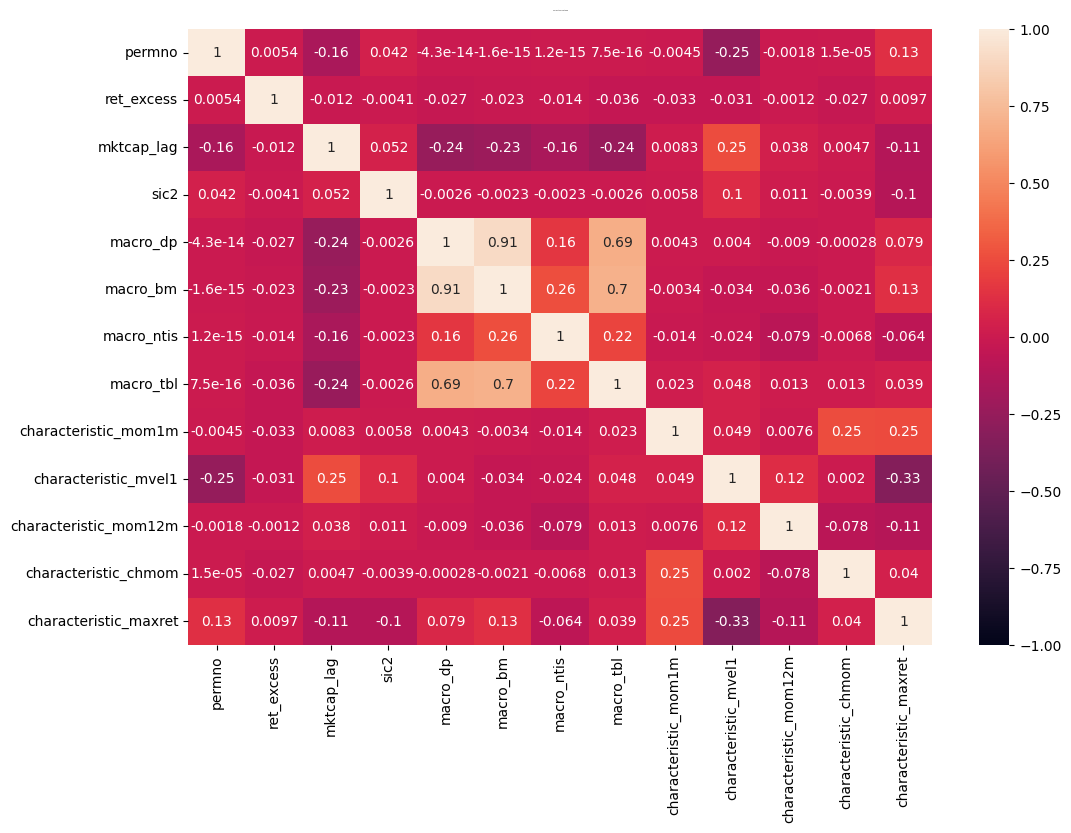

In [14]:
# Increase the size of the heatmap.
plt.figure(figsize=(12, 8))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':1}, pad=13);

<Axes: ylabel='Frequency'>

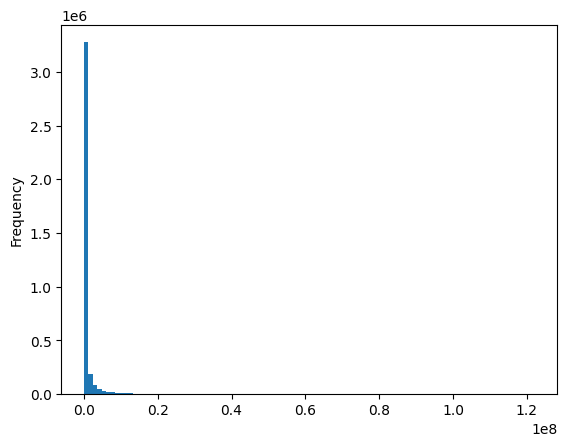

In [37]:
# install matplotlib
import matplotlib.pyplot as plt

# plot the distribution of the variable characteristic_mvel1
df['characteristic_mvel1'].plot.hist(bins=100)

# Example of LSTM

In [ ]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np